# 🧹LIMPEZA E TRANSFORMAÇÃO 🧹

Esta seção destina-se à execução de transformações essenciais para a realização de uma análise precisa. Alguns passos realizados são:

- Entedimento de campos nulos e possível preenchimento 
- Seleção e Validação de dados
- Classificação e Reclassificação de categorias

In [1]:
!pip install -r requirements.txt
import customFunctions as cF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
import json
import time
import spacy
from spacy.lang.pt.examples import sentences
from unidecode import unidecode

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns' ,None) 

In [4]:
listings = pd.read_csv('./listings.csv/listings.csv')

In [5]:
# Primeira impressão da base
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242625 entries, 0 to 242624
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   advertiser_id         242625 non-null  object
 1   portal                242625 non-null  object
 2   bedrooms              242625 non-null  int64 
 3   suites                242625 non-null  int64 
 4   parking_spaces        242625 non-null  int64 
 5   unit_type             242625 non-null  object
 6   year_delivered_at     11654 non-null   object
 7   display_address_type  242625 non-null  object
 8   city                  242625 non-null  object
 9   state                 242625 non-null  object
 10  neighborhood          242625 non-null  object
 11  street                228594 non-null  object
 12  CEP                   229108 non-null  object
 13  usable_areas          242625 non-null  int64 
 14  created_date          242625 non-null  object
 15  snapshot_date    

## CAMPOS NULOS 🗋
Campos que provavelmente precisarão de algum tipo de tratamento/atenção para realização de cálculos
> Apenas o _"year_delivered_at"_ não é relativo ao endereço. Pode ser um campo interessante de ser analisado na próxima seção


In [6]:
nulos = listings.isnull().sum()
nulos.loc[nulos>0]

year_delivered_at    230971
street                14031
CEP                   13517
street_number         82288
dtype: int64

## SELEÇAO DE DADOS 🔎
  
Como o objetivo da análise pressupõe uma análise de performance é preciso selecionar/transformar dados que sejam comparáveis.</br>
> Sendo a quantidade de leads a ser analisada referente ao mês de Maio/2019, anúncios criados dentro deste mês tiveram menos tempo de exposição do que os criados anteriormente.</br>
> Assim, apenas a performance de anúncios criados antes de Maio/2019 são comparáveis. 


_Mesmo com a criação de uma medida **leads/dia** anúncios com menos dias do que 31 dias de exibição seriam impactados e portanto não comparáveis_

In [7]:
# Formatar campos de datas e criar tempo de ativo do anúncio
listings['created_date'] = pd.to_datetime(listings['created_date'], format='%Y-%m-%d %H:%M:%S')
listings['snapshot_date'] = pd.to_datetime(listings['snapshot_date'])
listings['active_days'] = ( (listings['snapshot_date'].dt.date)  - (listings['created_date'].dt.date) ).dt.days + 1

# Filtrar dataframe de análise 
listings = listings.query('active_days > 31').copy()

# Sanity Check 
listings.shape

(212122, 20)

## CEP 🏡
Os valores de cep são padronizados, portanto os registros que não seguirem tal padrão podem não entregar a informação pretendida, acarretando em possíveis dúvidas e maior número de  _**leads**_. Dessa forma, os registros que não tiverem um formato e valor válido de CEP serão considerados não preenchidos.

In [8]:
# Criar uma coluna com o número de caracteres presente na coluna de CEP
listings['cep_char'] = listings['CEP'].map(lambda x: None if x is np.nan else len(x))

# Novo df + Sanity check
cep_values = listings[['CEP', 'cep_char']]
cep_values = cep_values[~cep_values['CEP'].isnull()].copy()
cep_values.head()

,CEP,cep_char
0,"9090640,0",9.0
1,"9850305,0",9.0
3,"9715140,0",9.0
4,"9041320,0",9.0
5,"9715140,0",9.0


In [9]:
# Contar ocorrência por CEP em um dataframe 
cep_values = cep_values.groupby('CEP').agg({"CEP": "count", "cep_char": ["max"]})
cep_values.columns = [f'{tupla[0]}_{tupla[1]}' for tupla in cep_values.columns]

In [10]:
# Agregar CEP´s por quantidade de caracteres e rankear por número de registros
cep_p_char = cep_values.groupby('cep_char_max')['CEP_count']
cep_values['ranking_index'] = cep_p_char.rank(method='first', ascending =False)
cep_values.reset_index(inplace=True)

#Criar tabela com os 5 cep´s mais frequentes para cada quantidade de caracteres
cep_values.pivot(index='ranking_index', columns='cep_char_max', values = 'CEP').head()

cep_char_max,3.0,6.0,7.0,8.0,9.0,10.0
ranking_index,,,,,,
1.0,"0,0","9120,0","96860,0","972515,0","9895400,0","90202700,0"
2.0,"1,0","9280,0",NaN,"930590,0","9080320,0","97211000,0"
3.0,NaN,"9220,0",NaN,"954118,0","9060050,0","23647061,0"
4.0,NaN,"9291,0",NaN,"958030,0","9715140,0","12954850,0"
5.0,NaN,"9190,0",NaN,NaN,"9070250,0","13800001,0"


### Takeaways

> Os ceps de ruas têm 8 dígitos, no entanto uma região pode ser identificada com apenas 5. </br>
> Ignorando a vírgula presente em todos os registros, aparentemente:
> - campos com 10 caracteres possuem um 0 a mais.
> - campos com 8 caractereres possum um 0 a menos.
> - campos com 6 e 7 caracteres podem se referir a uma região 

_Uma vez que para o endereço ser considerado completo a informação deve ser a mais precisa possível, serão desconsiderados os CEPs referentes a uma região (com menos de 8 dígitos)._

In [11]:
# Função personalizada que formata o campo de CEP no padrão nacional
listings_complete = listings.copy()
listings = cF.prettyCEP(listings,'CEP', 'CEP_adj').copy()

# Cria um novo df apenas com CEPS que podem se referir a uma rua específica
ceps_validos = listings[listings['cep_char']>=8]

### Enriquecimento da Base de Dados
> Obtenção de dados externos para validação dos ceps cadastrados em anúncios. </br>
> A verificação de CEP´s torna a análise mais precisa por assegurar que não há divergência no endereço cadastrado.</br>
> Endereços inconsistentes podem gerar dúvidas e _**leads**_.

_Os dados referentes ao endereçamento de cada CEP foram obtidos por meio da API **[AwesomeAPI](https://docs.awesomeapi.com.br/)**_

In [12]:
# Armazena os valores únicos de cep a serem consultados
lista_cep = [cep for cep in ceps_validos['CEP_adj'].unique()]

# Cria um dataframe com a e mesma estrtura da resposta recebida da API de CEP
CEP_validation = pd.DataFrame( {'CEP': lista_cep,
                                'cep': '',
                                'address_type': '',
                                'address_name': '',
                                'address': '',
                                'state': '',
                                'district': '',
                                'lat': '',
                                'lng': '',
                                'city': '',
                                'city_ibge': '',
                                'ddd': ''})

In [13]:
# Função personalizada para obtenção dos dados completos do endereço com base no CEP
def checkCEP(row):
    cep_code = row
    url = f'https://cep.awesomeapi.com.br/json/{cep_code}'
    r = requests.get(url)
    try:
        response = r.json()
    except:
        response = "ERRO"
    for header in response.keys():
        CEP_validation.loc[ CEP_validation['CEP'] == row, f'{header}'] = response[f'{header}']
        time.sleep(2)

_Para agilizar o processo, os dados foram armazenados em um arquivo csv e serão consumidos deste_

In [14]:
#CEP_validation = CEP_validation['CEP'].map(checkCEP)
#CEP_validation.to_csv('CEP_validation.csv', index=False)
CEP_validation = pd.read_csv('./CEP_validation.csv', sep =",",dtype=str)
CEP_validation.columns = [f'api_{col}' for col in CEP_validation.columns]

In [15]:
# Consolida a base original com a obtida
listings = pd.merge(listings, CEP_validation, left_on="CEP_adj", right_on="api_CEP", how ="left")

In [16]:
# Registra se o endereço cadastrado diverge do endereço referente ao CEP
listings['api_validation'] = (listings['street'] == listings['api_address'])

# Cria filtros para selecionar registros de endereços até então divergentes e que possam ser comparados de forma mais precisa
no_type = listings['api_address_type'].isnull()
no_street = listings['street'].isnull()
no_address = listings['api_address_name'].isnull()
validation = listings['api_validation']==False

# Novo df filtrado 
CEP_validation = listings[
                    (~no_type)
                    &(~no_street)
                    &(~no_address)
                    &(validation)
                ].copy()

CEP_validation.shape

(6840, 38)

In [17]:
# Formata os campos de endereço a serem comparados
CEP_validation['street'] = CEP_validation[['api_address_type', 'street' ]].apply(cF.PreparaCEP, axis=1)                                                                        
CEP_validation['api_address_name'] = CEP_validation['api_address_name'].map(lambda x: re.sub('[0-9]','', unidecode(x.upper())))

In [18]:
# Realiza o download e carrega o modelo padrão do pacote
nlp = spacy.load("pt_core_news_sm")

In [19]:
def getWhatMatters(column,lista):
    """Compila em uma lista, palavras de um vetor classificadas como 'nome próprio'ou 'substantivo' ou'verbo', mas não 'stopword'"""
    for doc in nlp.pipe(column.values):
        lista.append(
            [token.text for token in doc if ( (
                (token.pos_ == "PROPN") | (token.pos_ == "NOUN") | (token.pos_ == "VERB") ) 
                & (token.is_stop == False)) 
            ])
    return lista

In [20]:
# Cria listas para receber a lista de palavras selecionadas
original, enriched = list(), list()

# Seleciona e armazena palavras do endereço cadastrado  
CEP_validation['street2'] = getWhatMatters(CEP_validation['street'], original)
# Seleciona e armazena palavras do endereço referente ao CEP cadastrado
CEP_validation['api_address_2'] = getWhatMatters(CEP_validation['api_address_name'], enriched)

#Calcula a similaridade dos dois conjuntos anteriores
CEP_validation['similarity'] = CEP_validation[['street2','api_address_2']].apply(lambda x: 
                                                                                 nlp(" ".join(x[0])).similarity(
                                                                                     nlp(" ".join(x[1]))),
                                                                                 axis=1)


# Como a ideia é identificar se existem erros pequenos, como de digitação e nãos semânticos, utilizou-se o modelo "small".
# Este modelo não pretende identificar sentidos de contexto. Por isso o "UserWarning" abaixo.
# Os vetores vazios referidos são anúncios com CEP e sem Nome de rua

<ipython-input-20-2d2cf3cd194c>:11: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  nlp(" ".join(x[0])).similarity(
<ipython-input-20-2d2cf3cd194c>:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  nlp(" ".join(x[0])).similarity(


In [21]:
## Atualiza registro de convergência entre endereço de Rua e CEP
CEP_validation['api_validation'] = CEP_validation['street2'] == CEP_validation['api_address_2']

In [22]:
# Reduzindo o df para apenas registros incongruentes
CEP_validation = CEP_validation.query('api_validation == False').copy()

# Definição do ponto de similaridade limite que será aceito como mesmo endereço. Este ponto foi encontrado visualente e poderia ser otmizado no futuro.
CEP_validation_True = CEP_validation[CEP_validation['similarity']>0.821].copy()
CEP_validation_False = CEP_validation[CEP_validation['similarity']<=0.821].copy()

#Evidência de efetividade 
true_head = CEP_validation_True[['street','api_address_name', 'similarity']].sort_values(by="similarity", ascending=True).head()
false_head = CEP_validation_False[['street','api_address_name', 'similarity']].sort_values(by="similarity", ascending=False).head()
true_head.append(false_head).reset_index().style.apply(lambda x:['background: red' if x.name == 5 else '' for i in x], axis=1)

,index,street,api_address_name,similarity
0,186221,HELENA APARECIDA SECOL NOVA PETROPOLIS SAO BERNARDO DO CAMPO SP,HELENA APARECIDA SECOL,0.821203
1,49165,ALDINO PINOTI,ALDINO PINOTTI,0.821238
2,131983,ALDINO PINOTI,ALDINO PINOTTI,0.821238
3,172145,ALDINO PINOTI,ALDINO PINOTTI,0.821238
4,154244,ALDINO PINOTI,ALDINO PINOTTI,0.821238
5,82903,RUA SANTO ANDRE,FARIA LIMA,0.820694
6,99195,RUA SANTO ANDRE,FARIA LIMA,0.820694
7,89259,RUA SANTO ANDRE,FARIA LIMA,0.820694
8,102325,ADOLFO LUTZ,PEREIRA COUTINHO,0.820406
9,513,RUA MARLENE,FARIA LIMA,0.817635


In [23]:
# identifica os falso negativos
false_negatives = listings['listing_id'].isin(CEP_validation_True['listing_id'].values)

# corrige os valores classificados anteriormente
listings.loc[false_negatives, 'api_validation'] = True

## EXIBIÇÃO DE INFORMAÇÕES 📟
Ainda que o anúncio possua todas as informações cadastradas, este ainda pode não ser classificado como tendo o **endereço completo** por não exibir todas as informações cadsatradas para os possíveis leads.
> Portanto serão utilizados os campos de endereço e o registro de quais dados são exibidos para classificar os endereços em **_completo, nível de rua ou região_**</br>

In [24]:
# Construindo filtros

# Endereço
validated = listings["api_validation"] == False
no_cep = listings['CEP'].isnull()
no_street = listings['street'].isnull()
no_number = listings['street_number'].isnull()

#Exibição
disp_all = listings['display_address_type'] == "ALL"
disp_street = listings['display_address_type'] == "STREET"
disp_region = listings['display_address_type'] == "NEIGHBORHOOD"

In [25]:
#Construção de novos dataframes para conferência da lógica de reclassificação

# (Possui, CEP, rua e número) E (exibe tudo). 
full_address = listings[disp_all & ~no_cep & ~no_street & ~no_number]

# (Possui rua e CEP, mas não número e exibe tudo) OU (Possui rua e CEP e exibe até o nível de rua). 
full_street_address = listings[
    ( (~no_street & ~no_cep  & disp_all & no_number)  
    | (~no_street & ~no_cep & disp_street) 
    )]

# (Possui rua, mas não CEP nem número e exibe tudo) OU (Possui rua, sem CEP e exibe até o nível de rua). 
street_name_address = listings[
    ( (~no_street & no_cep & disp_all)  
    | (~no_street & no_cep & disp_street) 
    )]

# (Possui CEP, mas não rua nem número e exibe tudo) OU (Possui CEP, sem rua e exibe até o nível de rua). 
street_cep_address = listings[
    ( (~no_cep & no_street & disp_all) 
    | (~no_cep & no_street & disp_street) 
    )]

# (Exibe apenas o bairro) OU (não possui CEP ou não possui rua)
region_address = listings[disp_region | (no_cep & no_street)]

# Checando se a reclassificação é mutalamente exclusiva e coletivamente exaustiva
teste = pd.concat([listings, full_address, full_street_address, street_name_address,street_cep_address, region_address])
teste = teste['listing_id'].value_counts()

# Caso haja um registro repetido mais de 2 vezes no df, os filtros realizados possuem alguma intersecção 
teste.loc[teste!=2]

Series([], Name: listing_id, dtype: int64)

In [26]:
# Cria dicionário com a tag de classificação de cada caso 
tags = {"ENDEREÇO COMPLETO": full_address, 
        "RUA" : full_street_address, 
        "RUA" : street_name_address,
        "RUA" : street_cep_address,
        "BAIRRO" : region_address}

#Checar distribuição de registros
resultado = {key : len(tags[key].values) for key in tags.keys()}
print(f'{resultado}\n TOTAL:{sum(list(resultado.values()))}')

{'ENDEREÇO COMPLETO': 21996, 'RUA': 401, 'BAIRRO': 85871}
 TOTAL:108268


In [27]:
# Criar coluna de reclassificação

ids = listings['listing_id']
listings['address_info'] = "RUA"

for key in tags.keys():
    listings.loc[listings['listing_id'].isin(tags[key]['listing_id']),'address_info'] = key 

# Checa resultado
listings['address_info'].value_counts()

RUA                  104255
BAIRRO                85871
ENDEREÇO COMPLETO     21996
Name: address_info, dtype: int64

## MAIS DADOS!🎲
Para os próximos passos ter acesso à performance de cada anúncio pode ajudar.

In [28]:
# Importa nova base e combina com atual 
leads = pd.read_csv('./leads.csv/leads.csv')
merged = pd.merge(listings, leads, how ='left', on= 'listing_id')

## TIPO DO ANÚNCIO 📰
Este tópico tem como objetivo identificar e classficar os anúncios em **_"Aluguel"_** e **_"Venda"_**
> Existem registros que não se encaixam na definição que classifica anúncios em Aluguel e Venda. </br>
> A definição do tipo de anúncio impacta diretamente o valor percebido da oferta. </br>
> Como esta percepção é fator importante na geração de **_leads_**, os anúncios que não se encaixam na defnição serão sinalizados 

In [29]:
#Cria filtros baseado nas informações fornecidas (aluguel : 900 a 1500; venda: 120k+)
renting = (merged['price']>=900) & (merged['price']<=1500)
selling = (merged['price']>=120000)

merged['listing_type'] = "NÃO IDENTIFICADO"

merged.loc[renting,'listing_type'] = "ALUGUEL"
merged.loc[selling,'listing_type'] = "VENDA"

# Atribuios valores a um novo df para serem analisados
no_list_cat = merged[~(renting | selling)].copy()

# Distribuição dos valores de preço que não foram classificados
no_list_cat[['price']].describe().round().T

,count,mean,std,min,25%,50%,75%,max
price,7947.0,4413.0,14764.0,370.0,863.0,1890.0,2629.0,119953.0


### Takeaways
> Existem valores consideravelmente diferentes dos fornecidos para classificação.</br>
> Aparentemente a maior parte deles são relativos à Aluguel **_(mediana e média mais próximas de valores de aluguel do que de venda)_**.</br>
> No entanto, estes valores tão divergentes podem ser resultados de erros de digitação. 
> Por isso, serão utilzados como critérios os valores de R\\$/$m^2$

In [30]:
# Calcula o preço/metro2 de cada anúncio
merged['price/m2'] = merged[['price', 'usable_areas']].apply(lambda x: (x[0]/x[1]) if x[1] != 0 else 0, axis=1 )
no_list_cat['price/m2'] = no_list_cat[['price', 'usable_areas']].apply(lambda x: (x[0]/x[1]) if x[1] != 0 else 0, axis=1 )

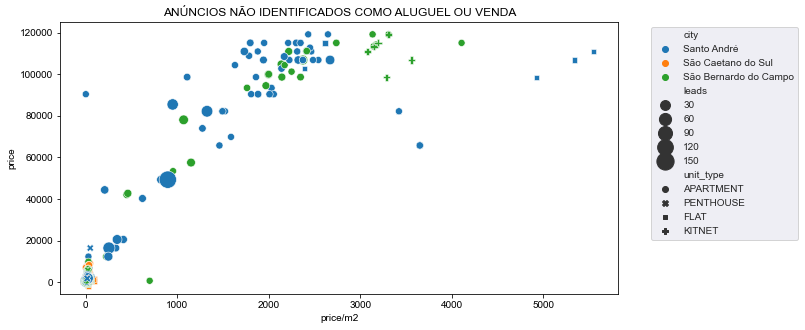

In [31]:
# Plota anúncios não categorizados com base no preço absoluto e por m2
fig, axs = plt.subplots(1,1, figsize=(10,5))
sns.set_style('darkgrid')
sns.scatterplot(y='price', x='price/m2', size ="leads" , sizes=(50, 300), hue='city', style='unit_type', data=no_list_cat)
axs.set_title("ANÚNCIOS NÃO IDENTIFICADOS COMO ALUGUEL OU VENDA")
plt.legend(bbox_to_anchor=(1.05, 1));

>_Nota-se que existem muitos pontos concentrados próximos à origem do gráfico, provavelmente referentes a aluguel e outros mais dispersos e próximos dos 120k._</br>
>_Considerando estas "concentrações" como clusters, chama atenção o anúncio de melhor performance estar em uma região intermediária._ </br>
>_Sendo este muito caro para um aluguel e muito barato para uma venda_ </br>
>_Outro fato peculiar é a presença de kitnets entre os **_preços/$m^2$_**  mais caros do gráfico e com valores próximos aos de apartamentos na mesma região._</br>


**Por conta da impossibilidade de se identificar com precisão estes casos, os anúncios serão segmentados com base nos valoees de m2 não outliers dos que já foram cadastrados**

In [32]:
# Armazena os valores de R$/m2 outliers para os grupos dentro da dinficção do enunciado do problema

out_rent = cF.HomeMadeStats(merged['price/m2'][renting]).outliers()
out_sell = cF.HomeMadeStats(merged['price/m2'][selling]).outliers()


# cria um novo dataframe com os anúncios que poderiam ser classificado como ALUGUEL com base no R$/m2
rent = no_list_cat[( no_list_cat['price/m2'] >= out_rent['min']) 
                & ( no_list_cat['price/m2'] <= out_rent['max'])]


# cria um novo dataframe com os anúncios que poderiam ser classificado como VENDA com base no R$/m2
sell = no_list_cat[(no_list_cat['price/m2'] >= out_sell['min']) 
                & (no_list_cat['price/m2'] <= out_sell['max'])]

# reclassifica anúncios que fora do padrão definido no enunciado do problema
merged.loc[merged['listing_id'].isin(rent['listing_id']), 'listing_type'] = 'ALUGUEL'
merged.loc[merged['listing_id'].isin(sell['listing_id']), 'listing_type'] = 'VENDA'

In [33]:
#armazena o dataframe para utilização no próximo notebook
%store merged

Stored 'merged' (DataFrame)


In [34]:
# armazena o dataframe em um documento como contingência 
merged.to_csv('merged.csv', index=False)

#### [VER ANÁLISE   $\Rightarrow $](2_Analise.ipynb)